![avatar](figures/front_banner_T1S0_new.png)

# Assignment 6: Appearance-based gaze estimation - Task 01

Author: `Yintao, Xu` | Date: `2020-02-12` | Email: xuyt@shanghaitech.edu.cn

Topics: `pandas`

## Section 0.1.1: Introduction

> Gaze tracking or gaze estimation is an important topic for understanding human visual attention. Such a technology has been widely deployed in various fields, such as human–computer interaction, visual behavior analysis, and psychological studies. Based on its huge potential value, many eye tracking devices (e.g., Tobii X3-120, Tobii EyeX, and Eye Tribe) have come into being. However, most of these devices are very expensive to purchase, making them hampered in wide adoption. Usually, **appearance-based gaze estimation employs a top-down strategy, which predicts the gaze direction or gaze point through eye images directly**. Such an approach is well established as another alternative for eye tracking since only achieving eye images is much cheaper. [1]

<img src="figures/gaze_est.png" style="zoom:80%" />

Many datasets are built to study this topic, including
- [ShanghaiTechGaze+](https://ieeexplore.ieee.org/document/8454246/authors#authors): a multi-view dataset with depth information
- [MPIIGaze](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/appearance-based-gaze-estimation-in-the-wild/): a dataset for estimating gaze direction
- [GazeCapture](https://gazecapture.csail.mit.edu/): provides a large-scale(~1474 subjects) on apple devices for estimating end-to-end postion on device.

## Section 0.1.2: Goal

In this assignment, you are expected to:
 - Know how to use `pandas` to learn about statistics of this dataset(30%).
 - Know how to use `numpy` to implement KNN to do gaze estimation(35%).
 - Know how to use `numpy` to implement convolution, Sobel(35%) and HOG-vectorization(bonus, 10%).
 - Have a gaze estimation demo! (In section 2, no points, but with a lot of fun!)
 
 <img src="figures/demo.png" style="zoom:50%" />

## Section 0.2.1: Download the MPIIGaze Dataset (csv version)

[MPIIGaze dataset(CVPR2015)](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/appearance-based-gaze-estimation-in-the-wild/) is a dataset for gaze estimation, which contains 213,659 images that we collected from 15 laptop users over several months in their daily life.

![](figures/MPIIGaze_Examples.png)

For this assignment, we modify the raw dataset into csv format for you to help you study this dataset by pandas. Exectuate following cells to guarantee that you could download the dataset from our mirror(at cells below).

In [13]:
# IMPORTANT: run this cell before runnng any cell to activate auto re-import
%load_ext autoreload
%autoreload 2

# 'gazelib' is the toolkit provided by this assignment, at the same directory of this notebook
from gazelib.utils import *
import matplotlib.pyplot as plt
import random
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# download the dataset
download_csv_mpIIdataset()

[GazeLib] Train csv has downloaded and passed md5 cheking.
[GazeLib] Test csv has downloaded and passed md5 cheking.


In [15]:
# load the dataset
train_df = load_train_csv_as_df()
train_df.head(10)

,subject_id,yaw,pitch,image_base64
0,5,-0.202976,-0.300898,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,5,0.153875,-0.216009,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,6,-0.240222,-0.231348,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,6,0.082681,-0.148303,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,11,0.141780,-0.259967,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,14,0.089140,-0.223431,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
6,6,-0.052793,-0.056385,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
7,13,-0.275569,-0.115087,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
8,5,0.095293,-0.210037,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
9,2,-0.066253,-0.250547,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


Run and read following codes for visualization
- Learn how to use `iloc` to get a row by index.
- Learn how to use `decode_base64_img` from `gazelib.utils` to decode images from a base64 encoded string

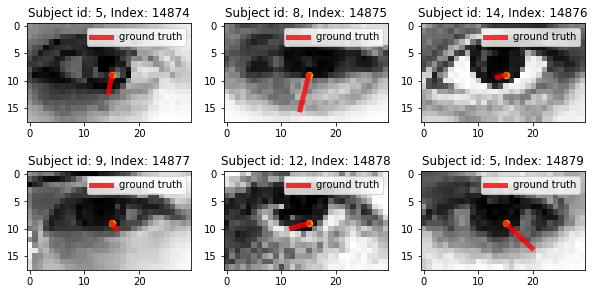

In [16]:
# visualize the eye images
plt.figure(figsize=(10, 5))
# randomly select an index, visualize following 6 images
start_idx = max(int(random.random() * len(train_df)) - 6, 0)

for offset in range(6):
    idx = offset + start_idx
    # Here, use iloc to get the row we want
    row = train_df.iloc[idx]
    
    plt.subplot(230 + offset + 1)
    # Please remember using decode_base64_img to decode image
    img_np = decode_base64_img(row['image_base64'])
    subject_id = row['subject_id']
    yaw, pitch = row['yaw'], row['pitch']
    xyz_gt = yaw_pitch2vec(np.array([yaw, pitch]))
    
    x_center, y_center = 15, 9
    length = 20
    
    plt.imshow(img_np, cmap="gray", vmin=0, vmax=256)
    plt.plot(
        [x_center, x_center + xyz_gt[0] * length],
        [y_center, y_center + xyz_gt[1] * length],
        linewidth=5, c="r", label="ground truth", alpha=0.8
    )
    plt.scatter([x_center], [y_center], s=40, c='orange')
    
    plt.legend()
    plt.title("Subject id: {}, Index: {}".format(subject_id, idx))
plt.show()

## Section 0.2.2 Dataset Introduction
- `subject_id`: the identifier for each subject
- `yaw`: a float in radian measure, indicating the gaze direction(see below figure)
- `pitch`: a float in radian measure, indicating the gaze direction(see below figure)
- `image_base64`: a string that encodes the image

<img src="figures/mpii_vis.png" style="zoom:70%" />

![](figures/front_banner_T1S1_new.png)

## Section 1: Pandas
### Section 1.1: Compute mean yaw & pitch of that guy! (5%)
**Goal**: Compute mean of yaw & pitch w.r.t. some subject.

**Note**: Please do not try to cheat local judge by modifying its codes or directly assigning the answer.
If you do so, you still cannot pass the online judge.

<u>Hints</u>:

- `pandas.DataFrame.groupby`: [Document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html?highlight=groupby#pandas.DataFrame.groupby)

In [17]:
import pandas as pd
from gazelib.task_1_judge import *
import copy

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/mean_of_tgt_subject`**

In [18]:
# Local Test - Section 1.1 (5%)
# Note: feel free to print out your result to debug if it cannot pass assert_eq
from AppearanceGazeEst import mean_of_tgt_subject

yaw_1, pitch_1 = mean_of_tgt_subject(train_df, 1)
yaw_10, pitch_10 = mean_of_tgt_subject(train_df, 10)

assert_eq(yaw_1, -0.000763)
assert_eq(pitch_1, -0.165573)
assert_eq(yaw_10, -0.000714)
assert_eq(pitch_10, -0.156507)

print("You pass the local test - Section 1.1 (5%)")

You pass the local test - Section 1.1 (5%)


### Section 1.2: Filter by yaw (5%)

**Goal**: Count the number of images that meet the requirement(in comment) of the function `count_tgt_subject`.

i.e. A function that counts the number of images of which yaw is larger(>) than yaw_threshold. 

<u>Hints</u>:

- `pandas.DataFrame.loc`: [Document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html)

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/count_tgt_subject`**

In [19]:
# Local Test - Section 1.2 (5%)
# Note: feel free to print out your result to debug if it cannot pass assert_eq
from AppearanceGazeEst import count_tgt_subject

assert_eq(count_tgt_subject(train_df, 0.02), 19571)
assert_eq(count_tgt_subject(train_df, -0.02), 22876)

print("You pass the local test - Section 1.2 (5%)")

You pass the local test - Section 1.2 (5%)


### Section 1.3: Get minimial value of target column (5%)

**Goal**: Get minimial value of target column specified by `col` with the function `get_min_val_of_tgt_col`.

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/get_min_val_of_tgt_col`**

In [20]:
from AppearanceGazeEst import get_min_val_of_tgt_col
# Local Test - Section 1.3 (5%)
# Note: feel free to print out your result to debug if it cannot pass assert_eq
assert_eq(get_min_val_of_tgt_col(train_df, 'yaw'), -0.7248519)

print("You pass the local test - Section 1.3 (5%)")

You pass the local test - Section 1.3 (5%)


### Section 1.4: Whose eyeball is the most active one? (5%)

**Goal**: Implement a function that sorts subject ids by standard deviation of their yaws, pitchs.

<u>Hints</u>:

- `pandas.DataFrame.sort_values`: [Document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/sort_ids_by_stdofcol`**

In [21]:
from AppearanceGazeEst import sort_ids_by_stdofcol
# Local Test - Section 1.4 (5%)
# Note: feel free to print out your result to debug if it cannot pass assert
# print(train_df)
assert sort_ids_by_stdofcol(train_df, 'yaw') == [11, 12, 1, 10, 2, 9, 4, 13, 3, 8, 7, 5, 6, 14]

print("You pass the local test - Section 1.4 (5%)")

You pass the local test - Section 1.4 (5%)


![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/compute_mean_eye`**

### Section 1.5: Mean eye is the perfect eye? (5%)

**Goal**: Psychological research once indicated that mean face is impressive to most people. At the same time mean face is also involved in [whitening](https://www.datasciencecentral.com/profiles/blogs/preprocessing-for-deep-learning-from-covariance-matrix-to-image) process, which is a popular preprocessing techique in face detection. Now, it is high time that you should compute the mean eye.

<u>Hints</u>:

- `pandas.DataFrame.iterrows`: [Document](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html)
- `decode_base64_img` from gazelib.utils

You pass the local test - Section 1.5 (5%)


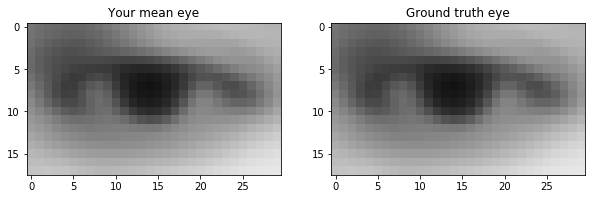

In [22]:
# Local Test - Section 1.5 (5%)
from AppearanceGazeEst import compute_mean_eye

mean_eye = compute_mean_eye(train_df)
check_im_similarity(mean_eye)

### Section 1.6: Does he or she wear eyeglasses? (5%)

**Goal**: Statistics in recent research paper shows that current algorithms are not robust to the subjects with eyeglasses. Imagine you are now a researcher who wants to study this problem. Before diving deeper, you should add a column in current data frame to inform you whether each row's subject wears eyeglasses or not.

<img src="figures/woglasses.png" style="zoom:50%" />

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/add_glasses_info`**

In [12]:
# Local Test - Section 1.6 (5%)
from AppearanceGazeEst import add_glasses_info

ret_df = add_glasses_info(train_df)


assert not ret_df.loc[0]['has_glasses']
assert ret_df.loc[12]['has_glasses']



print("You pass the local test - Section 1.6 (5%)")

ret_df.head(13)

You pass the local test - Section 1.6 (5%)


,subject_id,yaw,pitch,image_base64,has_glasses
0,5,-0.202976,-0.300898,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
1,5,0.153875,-0.216009,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
2,6,-0.240222,-0.231348,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
3,6,0.082681,-0.148303,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
4,11,0.141780,-0.259967,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
5,14,0.089140,-0.223431,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
6,6,-0.052793,-0.056385,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
7,13,-0.275569,-0.115087,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
8,5,0.095293,-0.210037,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False
9,2,-0.066253,-0.250547,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,False


![](figures/good_job_banner.png)
You should have completed **all cells(30%)** in this task locally when you reach here! You have been equipped with skills to get/set anything you want by pandas.

**checklist**
- mean_of_tgt_subject (5%)
- count_tgt_subject (5%)
- get_min_val_of_tgt_col (5%)
- sort_ids_by_stdofcol (5%)
- compute_mean_eye (5%)
- add_glasses_info (5%)


## Reference
```Bibtex
[1] @ARTICLE{
    8454246, 
    author={D. {Lian} and L. {Hu} and W. {Luo} and Y. {Xu} and L. {Duan} and J. {Yu} and S. {Gao}}, 
    journal={IEEE Transactions on Neural Networks and Learning Systems}, 
    title={Multiview Multitask Gaze Estimation With Deep Convolutional Neural Networks}, 
    year={2019}, 
    volume={30}, 
    number={10}, 
    pages={3010-3023}, 
    keywords={computer vision;convolutional neural nets;estimation theory;gaze tracking;multiview cameras;multiview gaze tracking data;convolutional neural networks architecture;multiview multitask gaze point estimation solution;multiview eye images;gaze direction estimation;deep convolutional neural networks;Estimation;Gaze tracking;Head;Task analysis;Feature extraction;Cameras;Robustness;Convolutional neural networks (CNNs);gaze tracking;multitask learning (MTL);multiview learning}, 
    doi={10.1109/TNNLS.2018.2865525}, 
    ISSN={2162-2388}, 
    month={Oct},
}
```